# Model Development: NASA - Nearest Earth Objects
<img src="../assets/nasa.jpg" alt="Title-Pic">

# Imports

In [118]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings

from pandas import Series, DataFrame
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, recall_score, f1_score


np.set_printoptions(suppress=True)
sns.set(rc={"figure.figsize": (12, 7), "axes.titlesize": 20, "axes.titleweight": "bold", "axes.labelsize": 15})
warnings.filterwarnings('ignore')

# Data

In [119]:
MODEL_DATA = np.load("../model_data/nasa_prep_data.npz", allow_pickle=True)
inputs = MODEL_DATA["inputs"]
targets = MODEL_DATA["targets"]
DATA_COLUMN_NAMES = MODEL_DATA["input_column_names"]

X_train, X_tmp_test, y_train, y_tmp_test = train_test_split(inputs, targets, test_size=0.2, random_state=101)
X_test, X_val, y_test, y_val = train_test_split(X_tmp_test, y_tmp_test, test_size=0.5, random_state=101)

y_train = y_train.reshape(-1)

(X_train.shape, X_test.shape, X_val.shape), (y_train.shape, y_test.shape, y_val.shape)

(((40400, 4), (5050, 4), (5050, 4)), ((40400,), (5050, 1), (5050, 1)))

# Build the Model

## Helper Functions

In [120]:
def export_model(model, model_name):
    timestamp_string = str(datetime.now())[:19].replace(" ", "").replace(":", "").replace("-", "")
    export_path = f"../trained_models/{timestamp_string}_{model_name}"
    with open(export_path, "wb") as model_file:
        pickle.dump(model, model_file)
    
    return export_path

def load_model(model_path):
    with open(model_path, "rb") as model_file:
        return pickle.load(model_file)

In [121]:
def print_top_rankings(grid_model, top=10):
    sorted_zipped_report = sorted(
        zip(
            grid_model.cv_results_["params"], 
            grid_model.cv_results_["mean_test_score"], 
            grid_model.cv_results_["rank_test_score"]
        ), key=lambda item: item[2]
    )
    for (i, (params, score, rank)) in enumerate(sorted_zipped_report):
        if i >= top:
            break

        print(f"Rank: {rank}\tScore: {score}\nParam: {params}\n")

def print_model_classification_report(model, X_data, y_data):
    preds_test = model.predict(X_data)
    preds_train = model.predict(X_train)

    f1_score_test = f1_score(y_data, preds_test, average="macro")
    recall_score_test = recall_score(y_data, preds_test)
    f1_score_train = f1_score(y_train, preds_train, average="macro")
    recall_score_train = recall_score(y_train, preds_train)

    print(f"Recall-Score:\t{recall_score_test}\t|\tTrain-Accuracy:\t{recall_score_train}")
    print(f"F1-Score:\t{f1_score_test}\t|\tTrain-F1-Score:\t{f1_score_train}\n")
    print(classification_report(y_data, preds_test))

    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_data, preds_test), annot=True, cmap="cool", fmt='.5g')

def print_feature_importance(model):
    return Series(data=model.feature_importances_, index=DATA_COLUMN_NAMES).sort_values(ascending=False)

## Model1: KNN Model

In [122]:
knn_tmp_model = KNeighborsClassifier()

knn_grid_params = {
    "n_neighbors": np.arange(8, 12, 2),
    "metric": ["manhattan", "euclidean"],
    "weights": ["uniform", "distance"]
}

knn_grid_model = GridSearchCV(knn_tmp_model, knn_grid_params, cv=5, scoring="recall", verbose=3)

knn_grid_model.fit(X_train, y_train);

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END metric=manhattan, n_neighbors=8, weights=uniform;, score=0.983 total time=   0.1s
[CV 2/5] END metric=manhattan, n_neighbors=8, weights=uniform;, score=0.985 total time=   0.1s
[CV 3/5] END metric=manhattan, n_neighbors=8, weights=uniform;, score=0.985 total time=   0.1s
[CV 4/5] END metric=manhattan, n_neighbors=8, weights=uniform;, score=0.980 total time=   0.1s
[CV 5/5] END metric=manhattan, n_neighbors=8, weights=uniform;, score=0.979 total time=   0.1s
[CV 1/5] END metric=manhattan, n_neighbors=8, weights=distance;, score=0.991 total time=   0.0s
[CV 2/5] END metric=manhattan, n_neighbors=8, weights=distance;, score=0.993 total time=   0.0s
[CV 3/5] END metric=manhattan, n_neighbors=8, weights=distance;, score=0.993 total time=   0.0s
[CV 4/5] END metric=manhattan, n_neighbors=8, weights=distance;, score=0.986 total time=   0.0s
[CV 5/5] END metric=manhattan, n_neighbors=8, weights=distance;, score=0.992 tota

In [123]:
knn_grid_model.best_params_

{'metric': 'euclidean', 'n_neighbors': 10, 'weights': 'distance'}

Recall-Score:	0.99185667752443	|	Train-Accuracy:	1.0
F1-Score:	0.9170403499325994	|	Train-F1-Score:	1.0

              precision    recall  f1-score   support

           0       0.99      0.85      0.91      2594
           1       0.86      0.99      0.92      2456

    accuracy                           0.92      5050
   macro avg       0.93      0.92      0.92      5050
weighted avg       0.93      0.92      0.92      5050



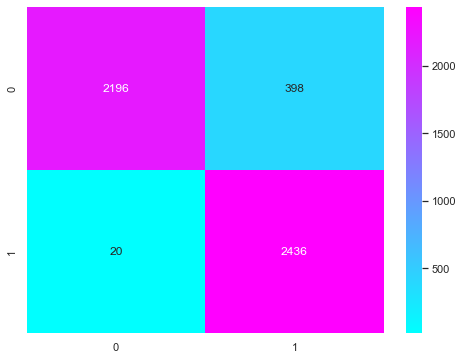

In [124]:
print_model_classification_report(knn_grid_model.best_estimator_, X_test, y_test)

In [125]:
print_top_rankings(knn_grid_model, 5)

Rank: 1	Score: 0.9925325009567196
Param: {'metric': 'euclidean', 'n_neighbors': 10, 'weights': 'distance'}

Rank: 2	Score: 0.9919390780524246
Param: {'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'distance'}

Rank: 3	Score: 0.9918896098418021
Param: {'metric': 'euclidean', 'n_neighbors': 8, 'weights': 'distance'}

Rank: 4	Score: 0.9910488581108424
Param: {'metric': 'manhattan', 'n_neighbors': 8, 'weights': 'distance'}

Rank: 5	Score: 0.9841750387272757
Param: {'metric': 'euclidean', 'n_neighbors': 10, 'weights': 'uniform'}



In [126]:
knn_best_model = knn_grid_model.best_estimator_

## Model2: RandomForest Model

In [127]:
rf_tmp_model = RandomForestClassifier()

rf_grid_params = {
    "criterion": ["gini"],
    "max_depth": [90],
    "min_samples_split": [7],
    "min_samples_leaf": [6],
    "n_estimators": [700],
    "max_samples": [0.9],
    "bootstrap": [True]
}

rf_grid_model = GridSearchCV(rf_tmp_model, rf_grid_params, cv=5, scoring="recall", verbose=3)

rf_grid_model.fit(X_train, y_train);

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END bootstrap=True, criterion=gini, max_depth=90, max_samples=0.9, min_samples_leaf=6, min_samples_split=7, n_estimators=700;, score=0.982 total time=  24.1s
[CV 2/5] END bootstrap=True, criterion=gini, max_depth=90, max_samples=0.9, min_samples_leaf=6, min_samples_split=7, n_estimators=700;, score=0.983 total time=  22.9s
[CV 3/5] END bootstrap=True, criterion=gini, max_depth=90, max_samples=0.9, min_samples_leaf=6, min_samples_split=7, n_estimators=700;, score=0.982 total time=  22.8s
[CV 4/5] END bootstrap=True, criterion=gini, max_depth=90, max_samples=0.9, min_samples_leaf=6, min_samples_split=7, n_estimators=700;, score=0.976 total time=  22.6s
[CV 5/5] END bootstrap=True, criterion=gini, max_depth=90, max_samples=0.9, min_samples_leaf=6, min_samples_split=7, n_estimators=700;, score=0.976 total time=  22.4s


In [128]:
rf_grid_model.best_params_

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 90,
 'max_samples': 0.9,
 'min_samples_leaf': 6,
 'min_samples_split': 7,
 'n_estimators': 700}

Recall-Score:	0.9780130293159609	|	Train-Accuracy:	0.9904554670886702
F1-Score:	0.9235055664779126	|	Train-F1-Score:	0.9528755505591163

              precision    recall  f1-score   support

           0       0.98      0.87      0.92      2594
           1       0.88      0.98      0.93      2456

    accuracy                           0.92      5050
   macro avg       0.93      0.93      0.92      5050
weighted avg       0.93      0.92      0.92      5050



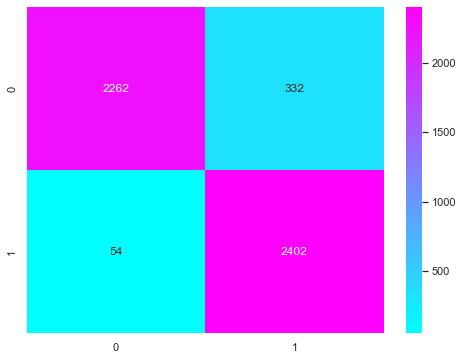

In [129]:
print_model_classification_report(rf_grid_model.best_estimator_, X_test, y_test)

In [130]:
print_top_rankings(rf_grid_model, 10)

Rank: 1	Score: 0.979773700664752
Param: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 90, 'max_samples': 0.9, 'min_samples_leaf': 6, 'min_samples_split': 7, 'n_estimators': 700}



In [131]:
rf_best_model = rf_grid_model.best_estimator_

## Model3: SVM Model

In [132]:
svm_tmp_model = SVC()

svm_grid_params = {
    "C": [7],
    "gamma": ["auto"],
    "kernel": ["rbf"],
    "degree": [1.5],
    "coef0": [0.8]
}

svm_grid_model = GridSearchCV(svm_tmp_model, svm_grid_params, cv=5, scoring="recall", verbose=3)

svm_grid_model.fit(X_train, y_train);

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END C=7, coef0=0.8, degree=1.5, gamma=auto, kernel=rbf;, score=0.994 total time=  10.3s
[CV 2/5] END C=7, coef0=0.8, degree=1.5, gamma=auto, kernel=rbf;, score=0.990 total time=  10.2s
[CV 3/5] END C=7, coef0=0.8, degree=1.5, gamma=auto, kernel=rbf;, score=0.989 total time=   9.8s
[CV 4/5] END C=7, coef0=0.8, degree=1.5, gamma=auto, kernel=rbf;, score=0.990 total time=   9.9s
[CV 5/5] END C=7, coef0=0.8, degree=1.5, gamma=auto, kernel=rbf;, score=0.992 total time=   9.8s


In [133]:
svm_grid_model.best_params_

{'C': 7, 'coef0': 0.8, 'degree': 1.5, 'gamma': 'auto', 'kernel': 'rbf'}

Recall-Score:	0.988599348534202	|	Train-Accuracy:	0.9908510953958756
F1-Score:	0.8736990157045623	|	Train-F1-Score:	0.8779123124066535

              precision    recall  f1-score   support

           0       0.99      0.77      0.86      2594
           1       0.80      0.99      0.88      2456

    accuracy                           0.87      5050
   macro avg       0.89      0.88      0.87      5050
weighted avg       0.90      0.87      0.87      5050



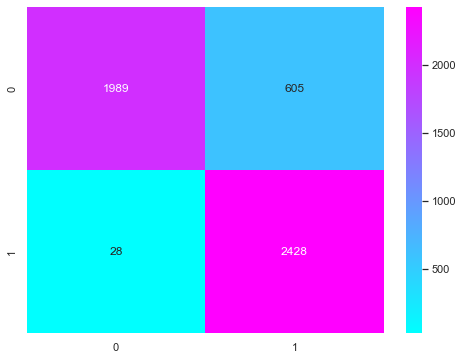

In [134]:
print_model_classification_report(svm_grid_model.best_estimator_, X_test, y_test)

In [135]:
print_top_rankings(svm_grid_model, 10)

Rank: 1	Score: 0.9908510586270433
Param: {'C': 7, 'coef0': 0.8, 'degree': 1.5, 'gamma': 'auto', 'kernel': 'rbf'}



In [136]:
svm_best_model = svm_grid_model.best_estimator_

## Model4: GradientBoost Model

In [137]:
xgb_tmp_model = XGBClassifier(nthread=-1,)

xgb_grid_params = {
    "eval_metric": ["logloss"],
    "learning_rate": [0.005],
    "min_child_weight": [7],
    "n_estimators": [700],
    "eta": [0.05],
    "gamma": [4],
    "subsample": [0.55],
    "max_depth": [10],
    "colsample_bytree": [0.65]
}

xgb_grid_model = GridSearchCV(xgb_tmp_model, xgb_grid_params, cv=5, scoring="recall", verbose=3)

xgb_grid_model.fit(X_train, y_train);

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END colsample_bytree=0.65, eta=0.05, eval_metric=logloss, gamma=4, learning_rate=0.005, max_depth=10, min_child_weight=7, n_estimators=700, subsample=0.55;, score=0.997 total time=   7.7s
[CV 2/5] END colsample_bytree=0.65, eta=0.05, eval_metric=logloss, gamma=4, learning_rate=0.005, max_depth=10, min_child_weight=7, n_estimators=700, subsample=0.55;, score=0.992 total time=   7.7s
[CV 3/5] END colsample_bytree=0.65, eta=0.05, eval_metric=logloss, gamma=4, learning_rate=0.005, max_depth=10, min_child_weight=7, n_estimators=700, subsample=0.55;, score=0.992 total time=   8.6s


KeyboardInterrupt: 

In [ ]:
xgb_grid_model.best_params_

{'colsample_bytree': 0.65,
 'eta': 0.05,
 'eval_metric': 'logloss',
 'gamma': 4,
 'learning_rate': 0.005,
 'max_depth': 10,
 'min_child_weight': 7,
 'n_estimators': 700,
 'subsample': 0.55}

Recall-Score:	0.9873778501628665	|	Train-Accuracy:	0.9943622966223233
F1-Score:	0.886721927038821	|	Train-F1-Score:	0.8989542933047826

              precision    recall  f1-score   support

           0       0.99      0.79      0.88      2594
           1       0.82      0.99      0.89      2456

    accuracy                           0.89      5050
   macro avg       0.90      0.89      0.89      5050
weighted avg       0.90      0.89      0.89      5050



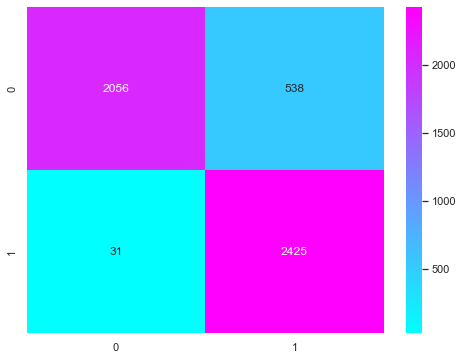

In [ ]:
print_model_classification_report(xgb_grid_model.best_estimator_, X_test, y_test)

In [ ]:
print_top_rankings(xgb_grid_model, 10)

Rank: 1	Score: 0.9921863824261921
Param: {'colsample_bytree': 0.65, 'eta': 0.05, 'eval_metric': 'logloss', 'gamma': 4, 'learning_rate': 0.005, 'max_depth': 10, 'min_child_weight': 7, 'n_estimators': 700, 'subsample': 0.55}



In [ ]:
xgb_best_model = xgb_grid_model.best_estimator_

## Ensemble Models

#### Best Recall-Ensemble-Model

In [ ]:
recall_models = Series(
    data=[
        recall_score(y_test, knn_best_model.predict(X_test)),
        recall_score(y_test, rf_best_model.predict(X_test)),
        recall_score(y_test, svm_best_model.predict(X_test)),
        recall_score(y_test, xgb_best_model.predict(X_test)),
    ],
    index=["KNN", "RandomForest", "SVM", "XGBoost"]
)

recall_models.sort_values(ascending=False)

KNN             0.991857
SVM             0.988599
XGBoost         0.987378
RandomForest    0.977199
dtype: float64

In [ ]:
knn_model_tuple = ("knn_best_model", knn_best_model)
xgb_model_tuple = ("xgb_best_model", xgb_best_model)
svm_model_tuple = ("svm_best_model", svm_best_model)
rf_model_tuple = ("rf_best_model", rf_best_model)

model_combo_1 = [knn_model_tuple, xgb_model_tuple, svm_model_tuple]
model_combo_2 = [knn_model_tuple, xgb_model_tuple, svm_model_tuple, rf_model_tuple]
model_best_combo = [knn_model_tuple, xgb_model_tuple, rf_model_tuple]

ensemble_recall_model_1 = VotingClassifier(estimators=model_combo_1)
ensemble_recall_model_2 = VotingClassifier(estimators=model_combo_2)
best_combo_test_model = VotingClassifier(estimators=model_best_combo)

ensemble_recall_model_1.fit(X_train, y_train)
ensemble_recall_model_2.fit(X_train, y_train)
best_combo_test_model.fit(X_train, y_train);

In [ ]:
recall_ensemble_models = Series(
    data=[
        recall_score(y_test, ensemble_recall_model_1.predict(X_test)),
        recall_score(y_test, ensemble_recall_model_2.predict(X_test)),
        recall_score(y_test, best_combo_test_model.predict(X_test)),
    ],
    index=["RECALL_COMBO1", "RECALL_COMBO2", "TEST_BEST_COMBO_F1_R"]
)

recall_ensemble_models.sort_values(ascending=False)

RECALL_COMBO1           0.994707
TEST_BEST_COMBO_F1_R    0.989414
RECALL_COMBO2           0.988192
dtype: float64

In [ ]:
ensemble_best_recall_model = ensemble_recall_model_1

In [ ]:
recall_models = Series(
    data=[
        recall_score(y_test, knn_best_model.predict(X_test)),
        recall_score(y_test, rf_best_model.predict(X_test)),
        recall_score(y_test, svm_best_model.predict(X_test)),
        recall_score(y_test, xgb_best_model.predict(X_test)),
        recall_score(y_test, ensemble_best_recall_model.predict(X_test)),
        recall_score(y_test, best_combo_test_model.predict(X_test)),
    ],
    index=["KNN", "RandomForest", "SVM", "XGBoost", "Ensemble_KNN_XGB_SVM", "Ensemble_KNN_XGB_RF"]
)

recall_models.sort_values(ascending=False)

Ensemble_KNN_XGB_SVM    0.994707
KNN                     0.991857
Ensemble_KNN_XGB_RF     0.989414
SVM                     0.988599
XGBoost                 0.987378
RandomForest            0.977199
dtype: float64

In [ ]:
best_recall_model = ensemble_best_recall_model

#### Best F1-Accuracy-Ensemble-Model

In [ ]:
f1_accuracy_models = Series(
    data=[
        f1_score(y_test, knn_best_model.predict(X_test)),
        f1_score(y_test, rf_best_model.predict(X_test)),
        f1_score(y_test, svm_best_model.predict(X_test)),
        f1_score(y_test, xgb_best_model.predict(X_test)),
        f1_score(y_test, ensemble_best_recall_model.predict(X_test)),
        f1_score(y_test, best_combo_test_model.predict(X_test)),
    ],
    index=["KNN", "RandomForest", "SVM", "XGBoost", "Ensemble_KNN_XGB_SVM", "Ensemble_KNN_XGB_RF"]
)

f1_accuracy_models.sort_values(ascending=False)

RandomForest            0.924677
KNN                     0.920983
Ensemble_KNN_XGB_RF     0.917154
Ensemble_KNN_XGB_SVM    0.896843
XGBoost                 0.894999
SVM                     0.884678
dtype: float64

In [ ]:
knn_model_tuple = ("knn_best_model", knn_best_model)
xgb_model_tuple = ("xgb_best_model", xgb_best_model)
svm_model_tuple = ("svm_best_model", svm_best_model)
rf_model_tuple = ("rf_best_model", rf_best_model)

model_combo_1 = [rf_model_tuple, knn_model_tuple, xgb_model_tuple]
model_combo_2 = [rf_model_tuple, knn_model_tuple, xgb_model_tuple, svm_model_tuple]

ensemble_accuracy_model_1 = VotingClassifier(estimators=model_combo_1)
ensemble_accuracy_model_2 = VotingClassifier(estimators=model_combo_2)

ensemble_accuracy_model_1.fit(X_train, y_train)
ensemble_accuracy_model_2.fit(X_train, y_train);

In [ ]:
f1_accuracy_ensemble_models = Series(
    data=[
        f1_score(y_test, ensemble_accuracy_model_1.predict(X_test)),
        f1_score(y_test, ensemble_accuracy_model_2.predict(X_test)),
    ],
    index=["Ensemble_RF_KNN_XGB", "Ensemble_RF_KNN_XGB_SVM"]
)

f1_accuracy_ensemble_models.sort_values(ascending=False)

Ensemble_RF_KNN_XGB        0.917012
Ensemble_RF_KNN_XGB_SVM    0.916226
dtype: float64

Recall-Score:	0.9898208469055375	|	Train-Accuracy:	0.9967855200039563
F1-Score:	0.9126537855503417	|	Train-F1-Score:	0.9564106666676486

              precision    recall  f1-score   support

           0       0.99      0.84      0.91      2594
           1       0.85      0.99      0.92      2456

    accuracy                           0.91      5050
   macro avg       0.92      0.91      0.91      5050
weighted avg       0.92      0.91      0.91      5050

Recall-Score:	0.988599348534202	|	Train-Accuracy:	0.9955986350823401
F1-Score:	0.9118632075471698	|	Train-F1-Score:	0.9563153754960942

              precision    recall  f1-score   support

           0       0.99      0.84      0.91      2594
           1       0.85      0.99      0.92      2456

    accuracy                           0.91      5050
   macro avg       0.92      0.91      0.91      5050
weighted avg       0.92      0.91      0.91      5050



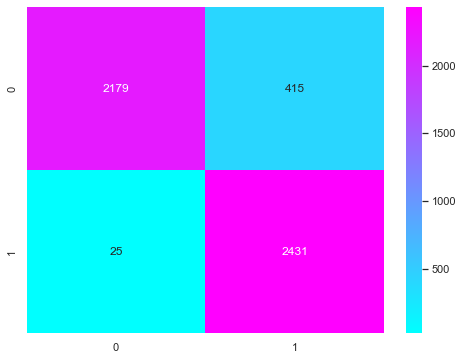

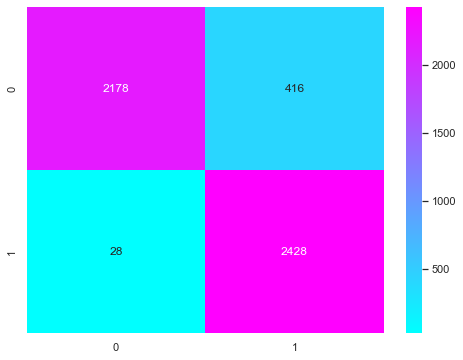

In [ ]:
print_model_classification_report(ensemble_accuracy_model_1, X_test, y_test)
print_model_classification_report(ensemble_accuracy_model_2, X_test, y_test)

In [ ]:
ensemble_best_f1_accuracy_model = ensemble_accuracy_model_2

In [ ]:
accuracy_models = Series(
    data=[
        f1_score(y_test, knn_best_model.predict(X_test)),
        f1_score(y_test, rf_best_model.predict(X_test)),
        f1_score(y_test, svm_best_model.predict(X_test)),
        f1_score(y_test, xgb_best_model.predict(X_test)),
        f1_score(y_test, ensemble_best_f1_accuracy_model.predict(X_test)),
        f1_score(y_test, best_combo_test_model.predict(X_test)),
    ],
    index=["KNN", "RandomForest", "SVM", "XGBoost", "Ensemble_RF_KNN_XGB_SVM", "Ensemble_KNN_XGB_RF"]
)

accuracy_models.sort_values(ascending=False)

RandomForest               0.924677
KNN                        0.920983
Ensemble_KNN_XGB_RF        0.917154
Ensemble_RF_KNN_XGB_SVM    0.916226
XGBoost                    0.894999
SVM                        0.884678
dtype: float64

Recall-Score:	0.9771986970684039	|	Train-Accuracy:	0.9904554670886702
F1-Score:	0.9225138515001147	|	Train-F1-Score:	0.952776031985489

              precision    recall  f1-score   support

           0       0.98      0.87      0.92      2594
           1       0.88      0.98      0.92      2456

    accuracy                           0.92      5050
   macro avg       0.93      0.92      0.92      5050
weighted avg       0.93      0.92      0.92      5050

Recall-Score:	0.99185667752443	|	Train-Accuracy:	1.0
F1-Score:	0.9170403499325994	|	Train-F1-Score:	1.0

              precision    recall  f1-score   support

           0       0.99      0.85      0.91      2594
           1       0.86      0.99      0.92      2456

    accuracy                           0.92      5050
   macro avg       0.93      0.92      0.92      5050
weighted avg       0.93      0.92      0.92      5050

Recall-Score:	0.988599348534202	|	Train-Accuracy:	0.9955986350823401
F1-Score:	0.9118632075471698	|	Train

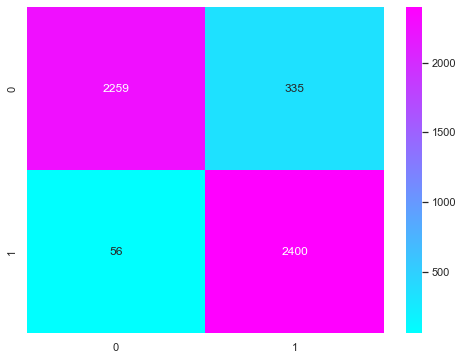

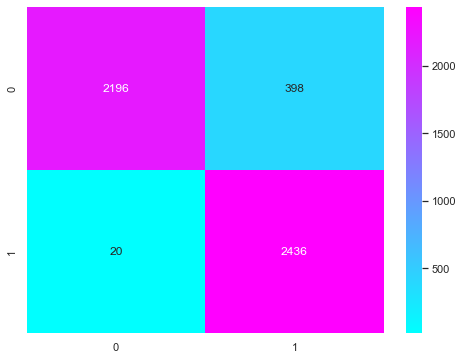

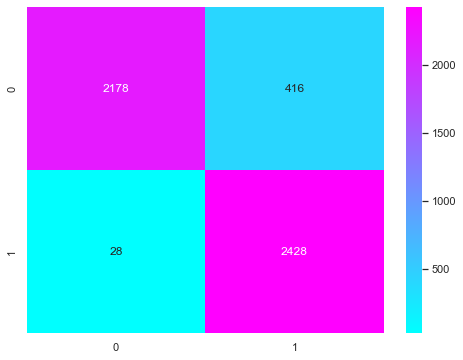

In [ ]:
print_model_classification_report(rf_best_model, X_test, y_test)
print_model_classification_report(knn_best_model, X_test, y_test)
print_model_classification_report(ensemble_best_f1_accuracy_model, X_test, y_test)

In [ ]:
best_accuracy_model = rf_best_model

# Final Model Selection

## Validate Models

In [ ]:
recall_models = Series(
    data=[
        recall_score(y_val, knn_best_model.predict(X_val)),
        recall_score(y_val, rf_best_model.predict(X_val)),
        recall_score(y_val, svm_best_model.predict(X_val)),
        recall_score(y_val, xgb_best_model.predict(X_val)),
        recall_score(y_val, best_recall_model.predict(X_val)),
        recall_score(y_val, ensemble_best_f1_accuracy_model.predict(X_val)),
    ],
    index=["KNN", "RandomForest", "SVM", "XGBoost", "Best_Recall_Model", "Ensemble_RF_KNN_XGB_SVM"]
)

recall_models.sort_values(ascending=False)

Best_Recall_Model          0.996891
KNN                        0.994559
XGBoost                    0.992616
Ensemble_RF_KNN_XGB_SVM    0.991838
SVM                        0.991450
RandomForest               0.980956
dtype: float64

In [ ]:
accuracy_models = Series(
    data=[
        f1_score(y_val, knn_best_model.predict(X_val)),
        f1_score(y_val, rf_best_model.predict(X_val)),
        f1_score(y_val, svm_best_model.predict(X_val)),
        f1_score(y_val, xgb_best_model.predict(X_val)),
        f1_score(y_val, best_recall_model.predict(X_val)),
        f1_score(y_val, ensemble_best_f1_accuracy_model.predict(X_val)),
    ],
    index=["KNN", "RandomForest", "SVM", "XGBoost", "Best_Recall_Model", "Ensemble_RF_KNN_XGB_SVM"]
)

accuracy_models.sort_values(ascending=False)

RandomForest               0.933432
KNN                        0.931731
Ensemble_RF_KNN_XGB_SVM    0.929352
XGBoost                    0.914265
Best_Recall_Model          0.912487
SVM                        0.901413
dtype: float64

Recall-Score:	0.9968907889623008	|	Train-Accuracy:	0.9976756836951683
F1-Score:	0.9013080908299225	|	Train-F1-Score:	0.9029377190753729

              precision    recall  f1-score   support

           0       1.00      0.80      0.89      2477
           1       0.84      1.00      0.91      2573

    accuracy                           0.90      5050
   macro avg       0.92      0.90      0.90      5050
weighted avg       0.92      0.90      0.90      5050

Recall-Score:	0.9945588806840264	|	Train-Accuracy:	1.0
F1-Score:	0.9251667107862005	|	Train-F1-Score:	1.0

              precision    recall  f1-score   support

           0       0.99      0.85      0.92      2477
           1       0.88      0.99      0.93      2573

    accuracy                           0.93      5050
   macro avg       0.93      0.92      0.93      5050
weighted avg       0.93      0.93      0.93      5050

Recall-Score:	0.9926156237854644	|	Train-Accuracy:	0.9943622966223233
F1-Score:	0.9040637172861519	|	T

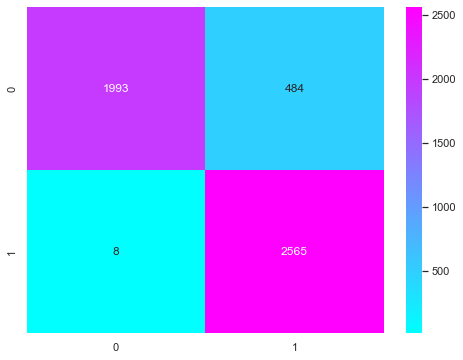

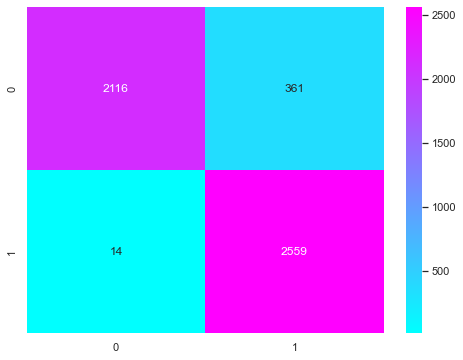

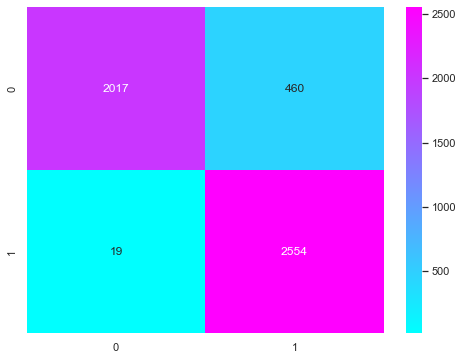

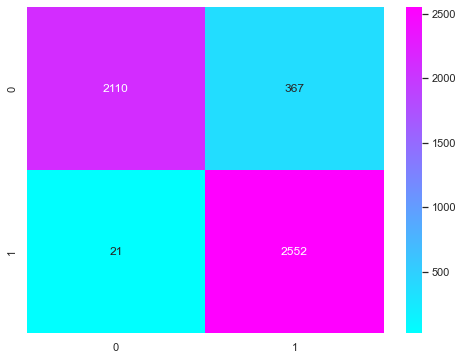

In [ ]:
print_model_classification_report(best_recall_model, X_val, y_val)
print_model_classification_report(knn_best_model, X_val, y_val)
print_model_classification_report(xgb_best_model, X_val, y_val)
print_model_classification_report(ensemble_best_f1_accuracy_model, X_val, y_val)

**We choose the best_recall_model, because it is the least overfitted model an has the best Recall-Score, witch is our primary KPI!**

## Select Model

In [ ]:
CHOSEN_BEST_MODEL = best_recall_model
MODEL_PREDICTIONS = CHOSEN_BEST_MODEL.predict(X_val)
MODEL_REPORT = classification_report(y_val, MODEL_PREDICTIONS)
RECALL_SCORE = f"{np.round(recall_score(y_val, MODEL_PREDICTIONS) * 100, 3)}%"
F1_SCORE = f"{np.round(f1_score(y_val, MODEL_PREDICTIONS) * 100, 3)}%"

print("REPORT:", MODEL_REPORT)
print("RECALL_SCORE:\t", RECALL_SCORE)
print("F1_SCORE:\t", F1_SCORE)

REPORT:               precision    recall  f1-score   support

           0       1.00      0.80      0.89      2477
           1       0.84      1.00      0.91      2573

    accuracy                           0.90      5050
   macro avg       0.92      0.90      0.90      5050
weighted avg       0.92      0.90      0.90      5050

RECALL_SCORE:	 99.689%
F1_SCORE:	 91.249%


# Export the Model

## Export

In [ ]:
# import pickle
# from datetime import datetime
# timestamp_string = str(datetime.now())[:19].replace(" ", "").replace(":", "").replace("-", "")

# with open(f"../trained_models/{timestamp_string}_knn_best_model", "wb") as model_file:
#     pickle.dump(CHOSEN_BEST_MODEL, model_file)

## Test Import

In [ ]:
# with open(f"../trained_models/{timestamp_string}_knn_best_model", "rb") as model_file:
#     my_imported_model = pickle.load(model_file)

# print(classification_report(y_val, my_imported_model.predict(X_val)))

# Test Model-Export in Class

In [ ]:
# class ModelWrapper:
#     def __init__(self, model, scaler):
#         self.model = model
#         self.scaler = scaler
    
#     def predict(self, values):
#         prep_values = self.preprocess_values(values)
#         pass

#     def preprocess_values(self, values):
#         pass

# my_wrapper_model = ModelWrapper(my_imported_model, None)
# timestamp_string = str(datetime.now())[:19].replace(" ", "").replace(":", "").replace("-", "")

# with open(f"../trained_models/{timestamp_string}_wrapper_model_best_model", "wb") as model_file:
#     pickle.dump(my_wrapper_model, model_file)

In [ ]:
# with open(f"../trained_models/{timestamp_string}_wrapper_model_best_model", "rb") as model_file:
#     my_imported_wrapper_model = pickle.load(model_file)

# print(my_imported_wrapper_model.model)